<a href="https://colab.research.google.com/github/lebatt11/kaggle-/blob/main/programme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Importation des bibliothéques nécessaires :

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
from PIL import Image as mpimg
import matplotlib.image as mpimg
drive.mount('/content/drive')
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

Mounted at /content/drive


# 2- Exploration des données :

# 2.1 Construction du chemin vers les répertoires du projet  :

In [23]:
cwd = os.getcwd()
main_file_path = os.path.join(cwd, 'programme.ipynb')


colab_notebooks_path = '/content/drive/My Drive/Colab Notebooks'


input_path = '/content/drive/My Drive/chest_xray'

train_path = os.path.join(input_path, 'train')
test_path = os.path.join(input_path, 'test')
val_path = os.path.join(input_path, 'val')

# 2.2 Visualisation de quelques images de l'ensemble de données :

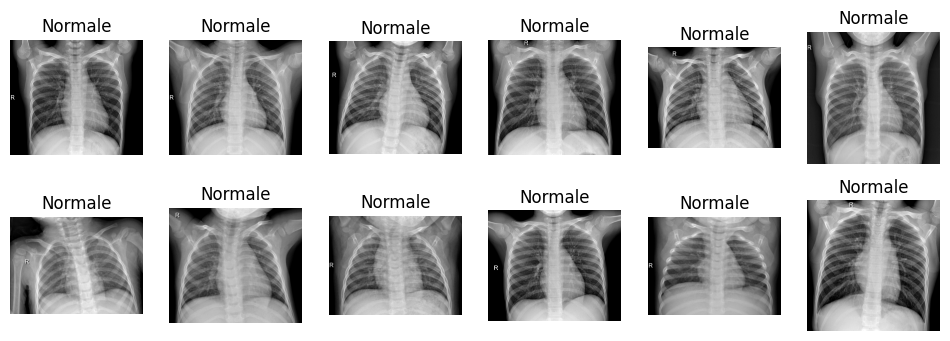

In [ ]:
import os
import matplotlib.pyplot as plt

input_path = '/content/drive/My Drive/chest_xray'

nows = 2
ncols = 6

train_path = input_path + '/train/NORMAL'


files = os.listdir(train_path)
rand_images = random.sample(files,nows*ncols)

fig = plt.gcf()
fig.set_size_inches(ncols*2, nows*2)


for i in range(len(rand_images)):
    sp = plt.subplot(nows, ncols, i + 1)
    plt.title("Normale")
    sp.axis('Off')

    img = mpimg.imread(train_path + '/' + rand_images[i])
    plt.imshow(img,cmap='gray')

plt.show()


# 2.3 Visualisation de quelques images anormales de l'ensemble de données :

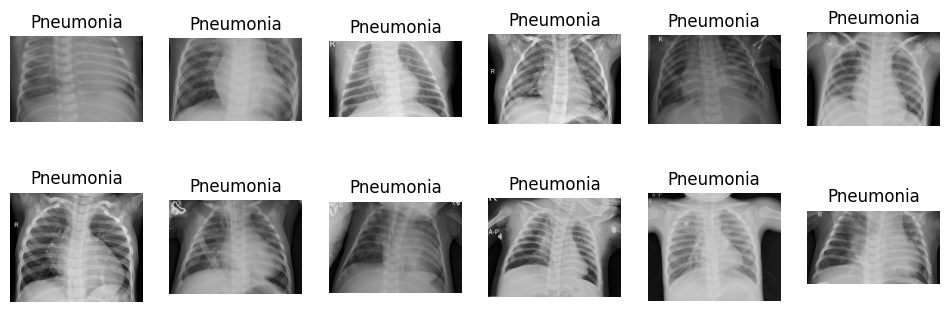

In [ ]:
nows = 2
ncols = 6

train_path = input_path + '/train/PNEUMONIA'


files = os.listdir(train_path)
rand_images = random.sample(files,nows*ncols)

fig = plt.gcf()
fig.set_size_inches(ncols*2, nows*2)


for i in range(len(rand_images)):
    sp = plt.subplot(nows, ncols, i + 1)
    plt.title("Pneumonia")
    sp.axis('Off')

    img = mpimg.imread(train_path + '/' + rand_images[i])
    plt.imshow(img,cmap='gray')

plt.show()

# 2.4- Voir les informations sur les répertoires :

In [ ]:
print("Le nombre d'images normales dans le répertoire train : ",len(os.listdir(input_path + "/train/NORMAL")))
print("Le nombre d'images anormales dans le répertoire train : ", len(os.listdir(input_path + "/train/PNEUMONIA")))

print("le nombre d'images normales dans le répertoire test : ",len(os.listdir(input_path + "/test/NORMAL")))
print("Le nombre d’images anormales dans le répertoire test : ",len(os.listdir(input_path + "/test/PNEUMONIA")))

print("Le nombre d'images normales dans le répertoire val : ",len(os.listdir(input_path + "/val/NORMAL")))
print("Le nombre d’images anormales dans le répertoire val : ",len(os.listdir(input_path + "/val/PNEUMONIA")))

Le nombre d'images normales dans le répertoire train :  1341
Le nombre d'images anormales dans le répertoire train :  3875
le nombre d'images normales dans le répertoire test :  234
Le nombre d’images anormales dans le répertoire test :  390
Le nombre d'images normales dans le répertoire val :  8
Le nombre d’images anormales dans le répertoire val :  8


# 3- prétraitement des données :

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def process_data(img_dims, batch_size, train_path, test_path):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
        test_path,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in os.listdir(test_path + cond):
            img = plt.imread(test_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

img_dims = 150
epochs = 10
batch_size = 32

train_path = '/content/drive/My Drive/chest_xray/train/'
test_path = '/content/drive/My Drive/chest_xray/test/'

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size, train_path, test_path)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 4- choix d'une architecture de réseau neuronal

In [22]:
inputs = Input(shape=(img_dims, img_dims, 3))

# prémiere couche convolutionnelle :
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Seconde couche convolutionnelle :
x = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Troisiéme couche convolutionnelle
x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# quatriéme  couche convolutionnelle
x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Cinquiéme couche convolutionnelle
x = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Couche entiérement connectée
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Couche de sortie
output = Dense(1, activation='sigmoid')(x)

# Création du modèle et compilation
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 separable_conv2d_16 (Separ  (None, 75, 75, 32)        688       
 ableConv2D)                                                     
                                                                 
 separable_conv2d_17 (Separ  (None, 75, 75, 32)        1344

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# 5- Entrainement du modéle :

In [14]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

<ipython-input-14-1556081dfae9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
163/163 [==============================] - 339s 2s/step - loss: 0.1190 - accuracy: 0.9551 - val_loss: 0.2696 - val_accuracy: 0.9276 - lr: 7.2900e-07
Epoch 2/10
163/163 [==============================] - 312s 2s/step - loss: 0.1223 - accuracy: 0.9557 - val_loss: 0.2761 - val_accuracy: 0.9260 - lr: 7.2900e-07
Epoch 3/10
163/163 [==============================] - 313s 2s/step - loss: 0.1214 - accuracy: 0.9576 - val_loss: 0.2663 - val_accuracy: 0.9260 - lr: 7.2900e-07
Epoch 4/10
163/163 [==============================] - 310s 2s/step - loss: 0.1211 - accuracy: 0.9584 - val_loss: 0.2767 - val_accuracy: 0.9243 - lr: 7.2900e-07
Epoch 5/10
163/163 [==============================] - 321s 2s/step - loss: 0.1186 - accuracy: 0.9559 - val_loss: 0.2768 - val_accuracy: 0.9260 - lr: 7.2900e-07
Epoch 6/10
163/163 [==============================] - 316s 2s/step - loss: 0.1166 - accuracy: 0.9567 - val_loss: 0.2800 - val_accuracy: 0.9243 - lr: 7.2900e-07
Epoch 7/10
163/163 [====================

# 6- évaluation du modéle sur l'ensemble de test(données non vues)

In [16]:
# Charger les poids optimaux
model.load_weights('best_weights.hdf5')

# Évaluation sur l'ensemble de test
evaluation = model.evaluate(test_data, test_labels)

# Afficher les résultats de l'évaluation
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

20/20 [==============================] - 7s 377ms/step - loss: 0.2485 - accuracy: 0.9247
Loss: 0.2485317885875702
Accuracy: 0.9246794581413269


# 7- Visualisation des résultats :

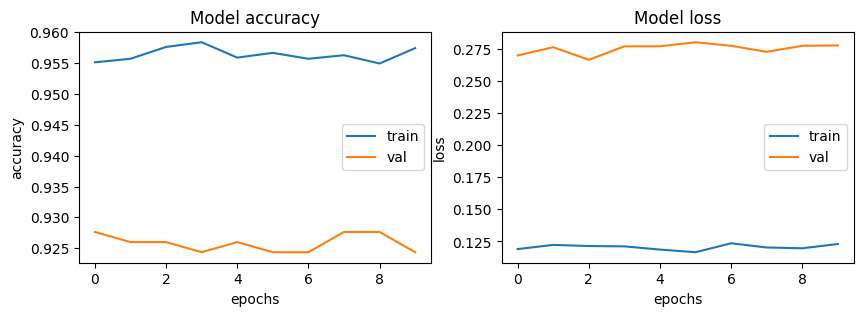

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 8-Affichage du matrice de confusion Prédiction et calcul de la précision, rappel et F1-score :

20/20 [==============================] - 9s 426ms/step
CONFUSION MATRIX ------------------
[[199  35]
 [ 12 378]]


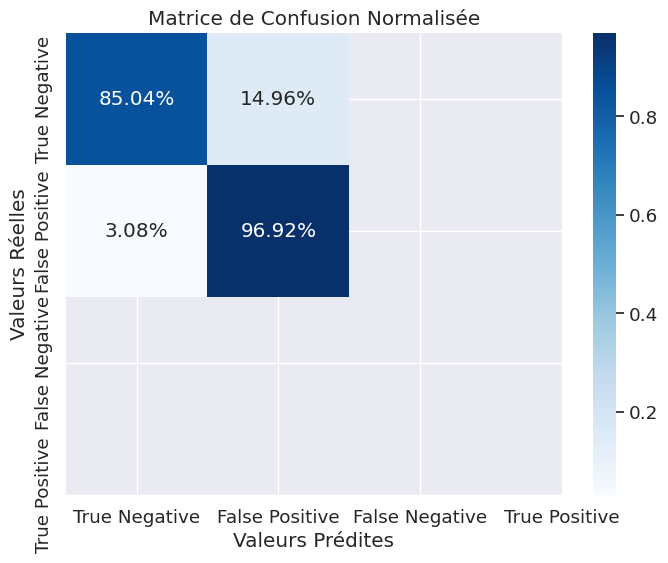

Sensibilité: 96.9231
Spécificité: 85.0427

TEST METRICS ----------------------
Exactitude: 92.46794871794873%
Précision: 91.52542372881356%
Rappel: 96.92307692307692%
Score F1: 94.14694894146949

TRAIN METRIC ----------------------


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des prédictions du modèle sur les données de test
preds = model.predict(test_data)

# Calcul de l'exactitude (accuracy)
acc = accuracy_score(test_labels, np.round(preds)) * 100

# Calcul de la matrice de confusion
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

# Définition des étiquettes des axes
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Conversion de la matrice en pourcentages pour une meilleure visualisation
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Configuration de la figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajuster la taille de la police
sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Ajout de titres et d'étiquettes
plt.title('Matrice de Confusion Normalisée')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.show()

# Calcul de la sensibilité (recall)
sensitivity = recall_score(test_labels, np.round(preds)) * 100

# Calcul de la spécificité
specificity = (tn / (tn + fp)) * 100

print("Sensibilité: {:.4f}".format(sensitivity))
print("Spécificité: {:.4f}".format(specificity))

print('\nTEST METRICS ----------------------')

# Calcul de la précision
precision = precision_score(test_labels, np.round(preds)) * 100

# Calcul du rappel (recall)
recall = tp / (tp + fn) * 100

# Calcul du score F1
f1_score = 2 * precision * recall / (precision + recall)

print('Exactitude: {}%'.format(acc))
print('Précision: {}%'.format(precision))
print('Rappel: {}%'.format(recall))
print('Score F1: {}'.format(f1_score))

print('\nTRAIN METRIC ----------------------')

# Cette ligne semble avoir été retirée, mais si elle est utilisée, assurez-vous que "hist" est bien défini.
# print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1]) * 100, 2)))

# 9- Le rapport de classification :

In [20]:
from sklearn.metrics import classification_report

# Génération du rapport de classification
class_report = classification_report(test_labels, np.round(preds), target_names=['NORMAL', 'PNEUMONIA'])

# Affichage du rapport de classification
print("Rapport de Classification :\n", class_report)

Rapport de Classification :
               precision    recall  f1-score   support

      NORMAL       0.94      0.85      0.89       234
   PNEUMONIA       0.92      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.92      0.92       624



# 10- Sauvegarde du modéle :

In [21]:
# Définir le chemin de sauvegarde du modèle
model_save_path = '/content/drive/My Drive/programme.h5'

# Sauvegarder le modèle
model.save(model_save_path)

print("Le modèle a été sauvegardé avec succès à l'emplacement :", model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Le modèle a été sauvegardé avec succès à l'emplacement : /content/drive/My Drive/programme.h5
